### 9:55pm EST, March 2nd, 2023 This analysis failed for prescription preprocessing. The prescription primary care data has ~75% entries with a BNF code but no CV2 code, and ~25% entries with CV2 and no BNF. The plan was to use UKB's primary care codings lookup file with BNF<->CV2 mappings to merge the BNF codes into the 25% missing them. This didn't work because for some reason, almost half of the CV2 codes (many unique values) were all matched to the BNF code "00.00.00.00" and I can't even find a record of what that code denotes. I emailed UKB tech support and am waiting for an answer.

### Next, I'll try just extracting generic names from the CV2 entries and try to merge them with the BNF drug classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime
from collections import Counter
import sys

In [2]:
'''Preprocess the raw data in the following steps:
1. Remove records before before 2006 based on an email from Jacob Weiser (jacob.weiser@mssm.edu), Thursday October 6th, 2022, 11:00am: 

>We do have a little over 1,000 records in the database from the 1990’s, I assume we got some of these from legacy systems, I also saw a few records dated about 1900 which are most likely just error records..
In terms of from when the data is well populated, 2006-2007 is when we started using epic here at Sinai -at least some departments- so disregarding data prior to these years makes sense as they will be sparsely populated.

2. Convert date columns to datetime format
3. Save files as parquet files
'''

'Preprocess the raw data in the following steps:\n1. Remove records before before 2006 based on an email from Jacob Weiser (jacob.weiser@mssm.edu), Thursday October 6th, 2022, 11:00am: \n\n>We do have a little over 1,000 records in the database from the 1990’s, I assume we got some of these from legacy systems, I also saw a few records dated about 1900 which are most likely just error records..\nIn terms of from when the data is well populated, 2006-2007 is when we started using epic here at Sinai -at least some departments- so disregarding data prior to these years makes sense as they will be sparsely populated.\n\n2. Convert date columns to datetime format\n3. Save files as parquet files\n'

In [ ]:
# Export to parquet for faster loading as we work :)

# med = pd.read_csv('../raw_data/data_gp_scripts.tsv', sep='\t') # Medications.txt', sep='|', encoding='cp1252', low_memory=False)
# med.to_parquet('../tidy_data/data_gp_scripts.parquet')

# read_v2_drugs_bnf = pd.read_excel('../all_lkps_maps_v3.xlsx', sheet_name='read_v2_drugs_bnf')
# read_v2_drugs_bnf.to_parquet('../tidy_data/read_v2_drugs_bnf.parquet')

There are 57,973,922 prescriptions in the UK Biobank Primary Care Prescription Record dataset. 73.52% of prescriptions have BNF but NaN for CV2, 0.78% have NaN for both, 1.96% have NaN for neither, and 23.74% have CV2 but NaN for BNF. 

It is this 23.74% we will run a merging procedure to fill BNFs for, and export a final prescriptions sheet with all prescriptions except for the ones with NaN for both CV2 and BNF, and use the BNFs (which will be all filled in at that point) to merge with a separate UKB Primary Care lookup table to obtain drug classes. This way, we can select all opioids, anti-dementia drugs, etc.

In [7]:
# # load prescriptions and lookup table for merging CV2 to BNF
# med = pd.read_parquet('../tidy_data/data_gp_scripts.parquet')
# read_v2_drugs_bnf = pd.read_parquet('../tidy_data/read_v2_drugs_bnf.parquet')

# # create subsets based on whether CV2 or BNF are NaN
# # nan_both_bnf_cv2 = med[(med.bnf_code.isna()) & (med.read_2.isna())]
# val_cv2_nan_bnf = med[(med.bnf_code.isna()) & ~(med.read_2.isna())]
# val_bnf_nan_cv2 = med[~(med.bnf_code.isna()) & (med.read_2.isna())]
# val_both = med[~(med.bnf_code.isna()) & ~(med.read_2.isna())]

# del med

# # ReadV2 codes in read_v2_drugs_bnf have a space at the end! Remove this
# new_entries = []
# for i,val in enumerate(read_v2_drugs_bnf.read_code):
#     new_entries.append(str(val)[:-1])
# read_v2_drugs_bnf.read_code = new_entries
    
# # Some ReadV2 codes in med have '00' at the end! Remove this from the subset we will be merging
# new_entries = []
# for i,val in enumerate(val_cv2_nan_bnf.read_2):
#     if str(val)[-2:] == '00':
#         new_entries.append(str(val)[:-2])
#     else:
#         new_entries.append(val)
# val_cv2_nan_bnf.read_2 = new_entries

# # merge with drug lookup table
# merge_val_cv2_nan_bnf = val_cv2_nan_bnf.merge(read_v2_drugs_bnf, how='left', left_on='read_2', right_on='read_code')

# del val_cv2_nan_bnf

# # drop column with NaN BNF codes and secondary ReadV2 codes
# merge_val_cv2_nan_bnf.drop(columns=['bnf_code_x', 'read_code'], inplace=True)
# merge_val_cv2_nan_bnf.rename(columns={"bnf_code_y": "bnf_code"}, inplace=True)

# # reorder columns to be the same as med
# merge_val_cv2_nan_bnf = merge_val_cv2_nan_bnf[val_cv2_nan_bnf.columns]

# # concatenate all rows that we need
# final_med = pd.concat([merge_val_cv2_nan_bnf, val_both, val_bnf_nan_cv2])

# del val_bnf_nan_cv2
# del val_both
# del merge_val_cv2_nan_bnf

# final_med.issue_date = pd.to_datetime(final_med.issue_date)
# final_med.to_parquet('../tidy_data/final_med_allBNF.parquet')

In [2]:
med = pd.read_parquet('../tidy_data/final_med_allBNF.parquet')

In [3]:
med.head()

,eid,bnf_code,drug_name,quantity,issue_date,read_2
0,1001378,02.04.00.00,METOPROLOL TARTRATE tabs 50mg,112.000,2011-09-14,bd6x.
1,1001378,06.06.02.00,ALENDRONIC ACID (AS SODIUM SALT) tabs 70mg,8.000,2012-04-16,fo4y.
2,1001378,02.05.05.01,LISINOPRIL tabs 20mg,56.000,2007-07-05,bi34.
3,1001378,02.05.04.00,Doxazosin 2mg tablets,56.000,2013-03-01,bh62.
4,1001378,02.04.00.00,Metoprolol 50mg tablets,112.000,2016-03-02,bd6x.


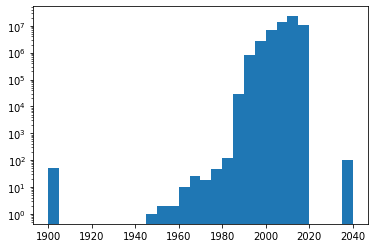

In [29]:
n,bins,patches = plt.hist(med.issue_date.dt.year, log=True, bins=np.arange(1900,2045,5))

In [30]:
pd.DataFrame({'n':n,'bins':bins[1:]})

,n,bins
0,53.0,1905
1,0.0,1910
2,0.0,1915
3,0.0,1920
4,0.0,1925
5,0.0,1930
6,0.0,1935
7,0.0,1940
8,0.0,1945
9,1.0,1950


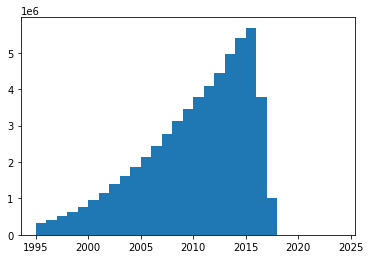

In [35]:
n,bins,patches = plt.hist(med.issue_date.dt.year, bins=np.arange(1995,2025,1))

In [34]:
pd.DataFrame({'n':n,'bins':bins[1:]})

,n,bins
0,324339.0,1996
1,417878.0,1997
2,519375.0,1998
3,624632.0,1999
4,766914.0,2000
5,942509.0,2001
6,1156213.0,2002
7,1384643.0,2003
8,1610272.0,2004
9,1873304.0,2005


In [ ]:
# print(med.shape)
# med.MEDICATION_START_DATE = pd.to_datetime(med.MEDICATION_START_DATE)
# med.MEDICATION_END_DATE = pd.to_datetime(med.MEDICATION_END_DATE)
# med = med[(med.MEDICATION_START_DATE>='2006-1-1') & (med.MEDICATION_START_DATE<='2040-1-1') &
#           (med.MEDICATION_END_DATE>='2006-1-1') & (med.MEDICATION_END_DATE<='2040-1-1') ]
# print(med.shape)
# med.PHARMACEUTICAL_CLASS = med.PHARMACEUTICAL_CLASS.str.upper()
# med.MEDICATION_NAME = med.MEDICATION_NAME.str.upper()
# med.MEDICATION_GENERIC_NAME = med.MEDICATION_GENERIC_NAME.str.upper()
# med.to_parquet('../tidy_data/Medications.parquet')